In [212]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("mdhasanahmad/12-mushroom-species-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/lquerol/.cache/kagglehub/datasets/mdhasanahmad/12-mushroom-species-dataset/versions/1


In [213]:
path = os.path.join(path, 'Data')
path

'/home/lquerol/.cache/kagglehub/datasets/mdhasanahmad/12-mushroom-species-dataset/versions/1/Data'

In [214]:
full = True  # Set to True if one wants to run the complete notebook, experiments and all

### Table Of Contents:
* [1. Dataset Exploration](#first-bullet)
* [2. Descriptor: SIFT vs Dense SIFT](#second-bullet)
* [3. Making the Codebook](#third-bullet)
* [4. Normalization](#fourth-bullet)
* [5. PCA](#fifth-bullet)
* [6. Considering the Role of Color](#sixth-bullet)
* [7. Metric Selection](#seventh-bullet)
* [8. Tuning Classiier Hyperparameters](#eighth-bullet)
* [9. Final Evaluation](#ninth-bullet)
* [10. Conclusions](#tenth-bullet)


In [215]:
import os
import pandas as pd
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm 
import time
from typing import List, Tuple, Dict, Optional

from sklearn.base import BaseEstimator
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer


random.seed(42)

### 1. Dataset Exploration <a class="anchor" id="first-bullet"></a>

In [216]:
classes = os.listdir(path)

data_split = [0.9, 0.05, 0.05]

# Mapping labels to numeric values
label_to_num = {cls: idx for idx, cls in enumerate(classes)}
num_to_label = {num: label for label, num in label_to_num.items()}

# DataFrame to hold file paths and labels
df = pd.DataFrame(columns=['file', 'label', 'split', 'label_num'])

for cls in classes:
    files = os.listdir(os.path.join(path, cls))
    random.shuffle(files)
    
    # File paths and labels
    files = [os.path.join(cls, file) for file in files]
    train_size = int(len(files) * data_split[0])
    val_size = int(len(files) * data_split[1])
    test_size = len(files) - train_size - val_size
    split_list = ['train']*train_size + ['val']*val_size + ['test']*test_size

    df = pd.concat([df, pd.DataFrame({
        'file': files,
        'label': [cls] * len(files),
        'split': split_list,
        'label_num': [label_to_num[cls]] * len(files)
    })], ignore_index=True)

classes

['Cortinarius',
 'Agaricus',
 'Entoloma',
 'Russula',
 'Suillus',
 'Inocybe',
 'Pluteus',
 'Hygrocybe',
 'Amanita',
 'Boletus',
 'Lactarius',
 'Exidia']

In [217]:
df

file        label  split  \
0      Cortinarius/Cortinarius_original_301_BY2YjnDmm...  Cortinarius  train   
1      Cortinarius/Cortinarius_original_000_Pw3qUBVmw...  Cortinarius  train   
2      Cortinarius/Cortinarius_original_072_dxjDz-yiX...  Cortinarius  train   
3      Cortinarius/Cortinarius_original_941_v3dkljHQh...  Cortinarius  train   
4      Cortinarius/Cortinarius_original_698_hDYmajbNT...  Cortinarius  train   
...                                                  ...          ...    ...   
11995  Exidia/Exidia_original_Exidia_original_TS2011P...       Exidia   test   
11996  Exidia/Exidia_original_TIL2017-9190084_BJQTBLw...       Exidia   test   
11997  Exidia/Exidia_original_Exidia_original_JM2009P...       Exidia   test   
11998  Exidia/Exidia_original_Exidia_original_TOB2015...       Exidia   test   
11999  Exidia/Exidia_original_Exidia_original_FDE2014...       Exidia   test   

      label_num  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
11995        11  
11996        11  
11997        11  
11998        11  
11999        11  

[12000 rows x 4 columns]

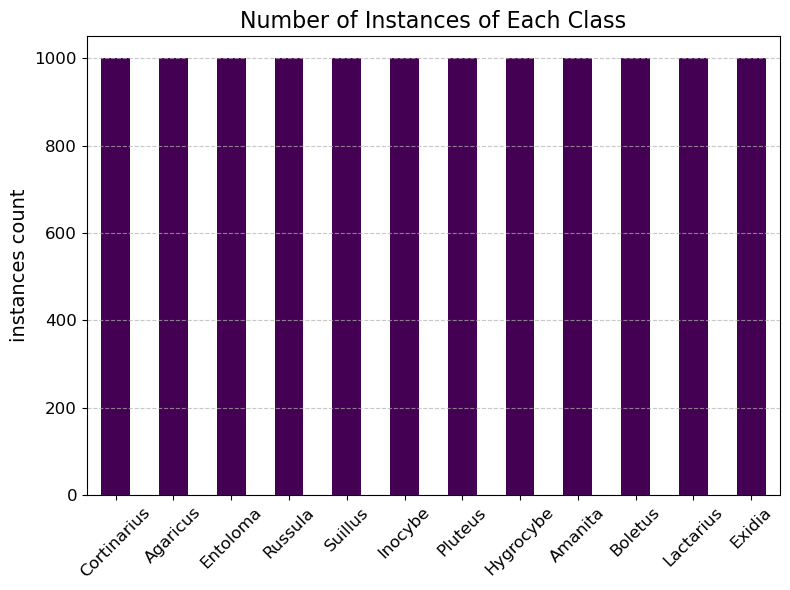

In [218]:
# Count the occurrences of each class
class_counts = df['label_num'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', colormap='viridis')
plt.title('Number of Instances of Each Class', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('instances count', fontsize=14)
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

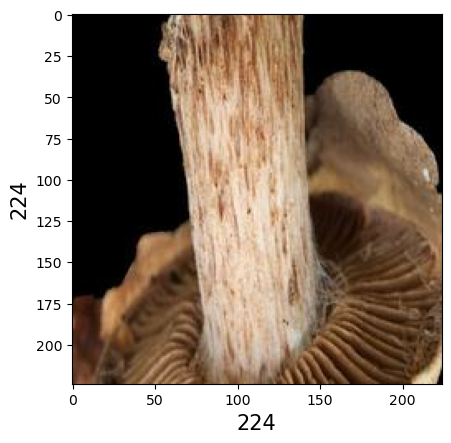

In [219]:
file = df['file'].values[6]
img = cv.imread(os.path.join(path, file))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.xlabel(img.shape[1], fontsize=15)
plt.ylabel(img.shape[0], fontsize=15)
plt.show()

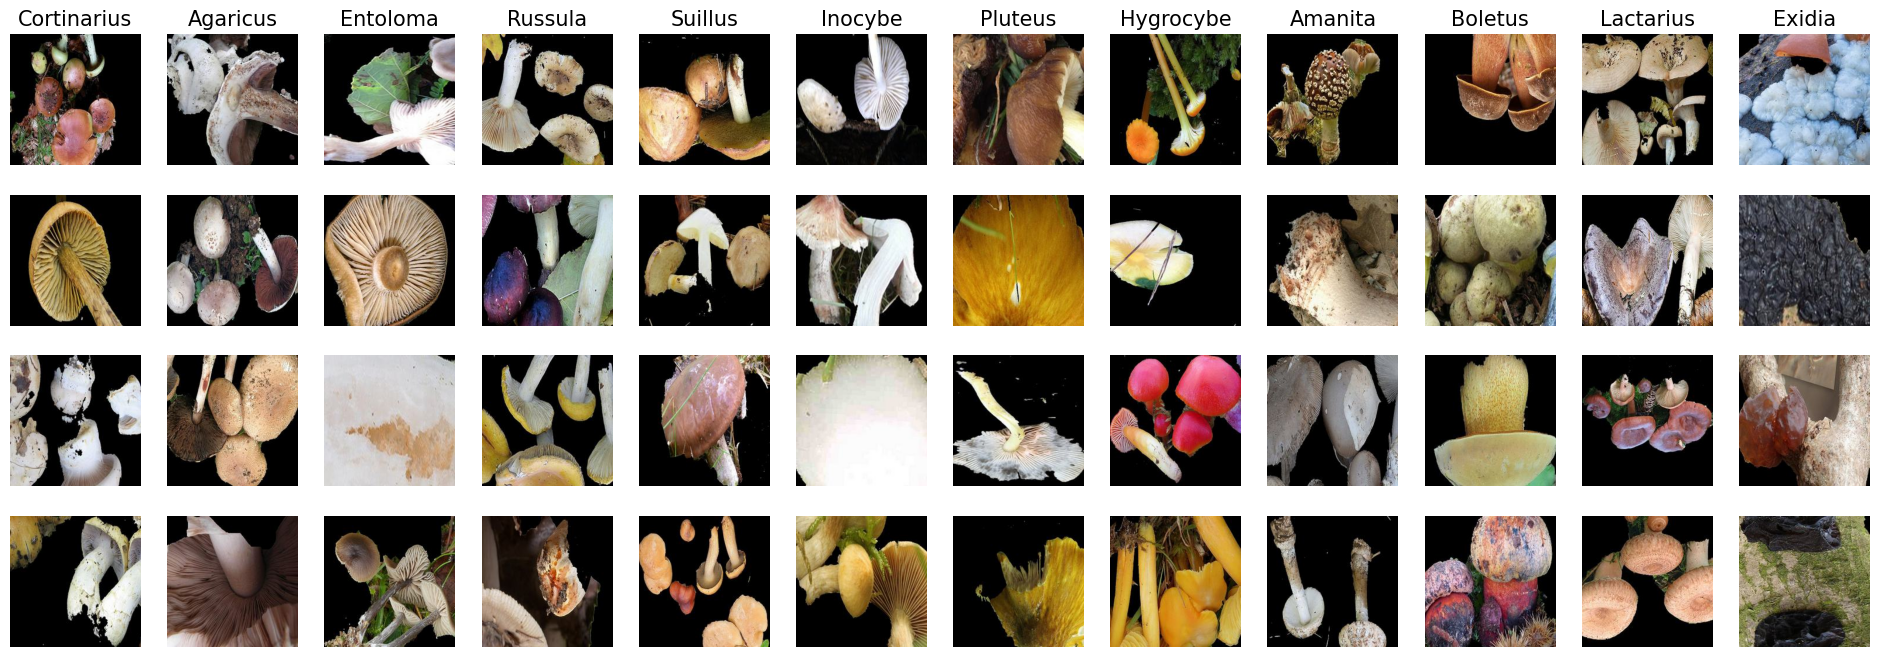

In [220]:
def visualize_dataset(df, n):
    labels = np.unique(df['label_num'])
    fig, axs = plt.subplots(n, len(labels), figsize=(n*6, n*2))
    for i, label in enumerate(labels):
        subset = df[df['label_num']==label]
        idxs = random.sample(range(0, len(subset)), n)
        axs[0, i].set_title(num_to_label[label], fontsize=15)
        for j, idx in enumerate(idxs):
            file = subset['file'].values[idx]
            img = cv.imread(os.path.join(path, file))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            axs[j, i].imshow(img)
            axs[j, i].axis('off')
    plt.show()

visualize_dataset(df, 4)

### 2. Descriptor: SIFT vs Dense SIFT <a class="anchor" id="second-bullet"></a>

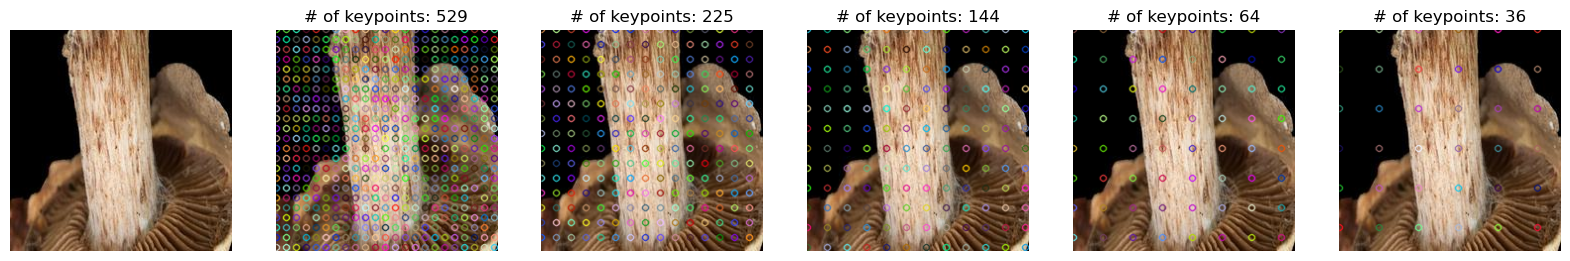

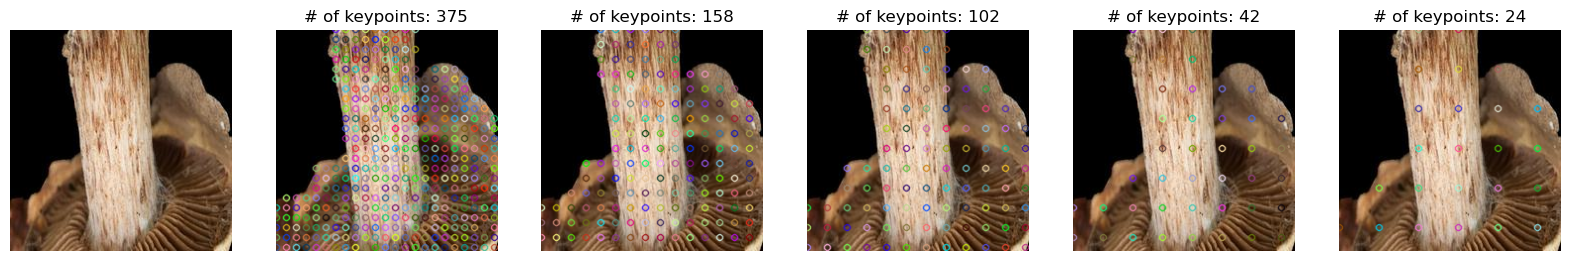

In [221]:
def create_dense_kp(img_shape, step_size, mask=None):
    keypoints = []
    step_size = int(step_size)
    if mask is None:
        keypoints += [cv.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size)
                                                          for x in range(0, img_shape[1], step_size)]
    else:
        keypoints += [cv.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size)
                                                            for x in range(0, img_shape[1], step_size) if mask[y, x] > 0]
    return keypoints

sift = cv.SIFT_create()

idx = 6
file, label = df['file'].values[idx], df['label'].values[idx]
im = cv.imread(os.path.join(path, file))
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
mask = (gray > 10).astype(np.uint8)

steps = [10, 15, 20, 30, 40]
dense_kps = []
for step in steps:
    kp = create_dense_kp(mask.shape, step_size=step, mask=None)
    dense_kps.append(kp)

# Draw keypoints on the image using OpenCV
fig, axs = plt.subplots(1, len(steps)+1, figsize=(20, 10))
axs[0].imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
axs[0].axis('off')
for i, kps in enumerate(dense_kps):
    img_with_kp = cv.drawKeypoints(im, kps, None)
    axs[i+1].imshow(cv.cvtColor(img_with_kp, cv.COLOR_BGR2RGB))
    axs[i+1].axis('off')
    axs[i+1].set_title('# of keypoints: '+str(len(kps)))

plt.show()

dense_kps = []
for step in steps:
    kp = create_dense_kp(mask.shape, step, mask=mask)
    dense_kps.append(kp)

# Draw keypoints on the image using OpenCV
fig, axs = plt.subplots(1, len(steps)+1, figsize=(20, 10))
axs[0].imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
axs[0].axis('off')
for i, kps in enumerate(dense_kps):
    img_with_kp = cv.drawKeypoints(im, kps, None)
    axs[i+1].imshow(cv.cvtColor(img_with_kp, cv.COLOR_BGR2RGB))
    axs[i+1].axis('off')
    axs[i+1].set_title('# of keypoints: '+str(len(kps)))

plt.show()

In [222]:
def extract_sift_features(im, sift, dense, v, mask=None):
    if dense:
        kp = create_dense_kp(im.shape, v, mask=mask)
        kp, des = sift.compute(im, kp)
    else:
        kp, des = sift.detectAndCompute(im, None)
    return kp, des


def get_sift_features(data_df, path, dense, v):
    if dense:
        sift = cv.SIFT_create()
    else:
        sift = cv.SIFT_create(v)

    def process_row(row):
        file, label = row['file'], row['label']
        im = cv.imread(os.path.join(path, file))
        
        gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        mask = (gray > 8).astype(np.uint8)

        kp, des = extract_sift_features(gray, sift, dense, v, mask)
        # print(len(des))

        row['sift_descriptors'] = des
        row['sift_kp'] = kp 

        return row

    tqdm.pandas()
    data_df = data_df.progress_apply(process_row, axis=1)

    return data_df

def get_bovw_histograms(df, model, num_clusters, col):
    histograms = []  # List to store histograms for each image
    
    for img_descriptors in df[col]:
        histogram = np.zeros(num_clusters)  # Initialize histogram
        img_descriptors = np.array(img_descriptors, dtype=np.float32)
        visual_word_indices = model.predict(img_descriptors)  # Predict cluster indices
        for ind in visual_word_indices:
            histogram[ind] += 1  # Increment cluster index counts
        histograms.append(histogram)  # Append the histogram
    
    # Add histograms as a new column in the DataFrame
    df = df.copy()
    df.loc[:, 'bovw_histograms'] = histograms
    return df

def get_bovw_features(df):
    df = df.copy()
    df.loc[:, 'features'] = df.loc[:, 'bovw_histograms']
    return df

def get_matrixs(df, split):
    X = np.vstack(df[df['split'].isin(split)]['features'].values)
    y = np.array(df[df['split'].isin(split)]['label_num'])
    return X, y

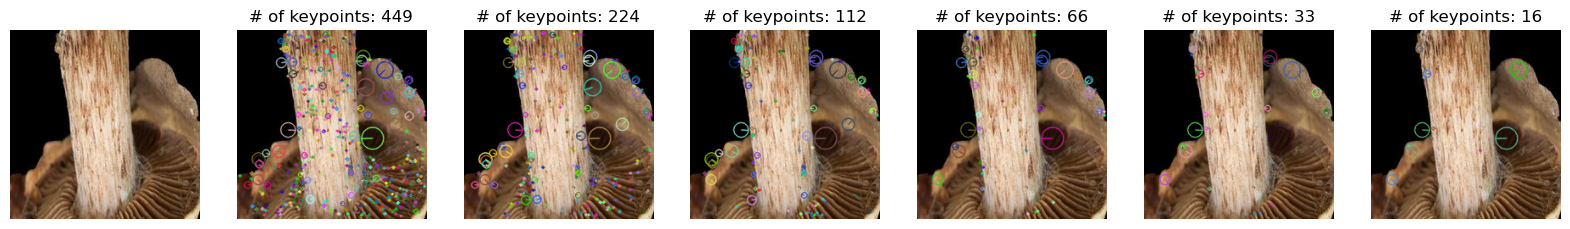

In [223]:
n_kps = [448, 224, 112, 66, 33, 16]

# Draw keypoints on the image using OpenCV
fig, axs = plt.subplots(1, len(n_kps)+1, figsize=(20, 10))
axs[0].imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
axs[0].axis('off')

for i, n_kp in enumerate(n_kps):
    sift = cv.SIFT_create(n_kp)
    kps = sift.detect(gray, mask=None)
    img_with_kp = cv.drawKeypoints(im, kps, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    axs[i+1].imshow(cv.cvtColor(img_with_kp, cv.COLOR_BGR2RGB))
    axs[i+1].axis('off')
    axs[i+1].set_title('# of keypoints: '+str(len(kps)))

plt.show()

Comparison using a baseline algorithm.

In [224]:
def list_of_dicts_to_latex_table(data):
    if not data:
        return "No data provided"

    # Extract headers from the first dictionary's keys
    headers = list(data[0].keys())

    # Start building the LaTeX table
    latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|" + "c|" * len(headers) + "}\n\\hline\n"
    latex_table += " & ".join(headers) + " \\\\ \\hline\n"

    # Add rows to the table
    for row in data:
        row_data = " & ".join(
            f"{value:.2f}" if isinstance(value, (float, int)) else str(value)
            for value in (row[key] for key in headers)
        )
        latex_table += row_data + " \\\\ \n"
    
    latex_table += "\\hline\n\\end{tabular}\n\\caption{Example Table from List of Dictionaries}\n\\label{tab:example}\n\\end{table}"
    return latex_table

if full:
    sift_params = []
    step_size_list = np.arange(5, 36, 5)
    n_keypoints_list = 2 ** np.arange(4, 10, 1)

    for step in step_size_list:
        sift_params.append({'dense': True, 'v': step})

    for n in n_keypoints_list:
        sift_params.append({'dense': False, 'v': n})

    print(sift_params)

    num_clusters = 50
    for params in sift_params:
        print(params)
        start_time = time.time()
        data = get_sift_features(df, path, params['dense'], params['v'])
        data = data.dropna()
        sift_descriptors = [item for sublist in data[data['split'] == 'train']['sift_descriptors'] for item in sublist]
        km = MiniBatchKMeans(n_clusters=num_clusters, batch_size=1000, n_init=10, max_iter=100, random_state=42)
        km.fit(sift_descriptors)
        km.cluster_centers_ = km.cluster_centers_.astype(np.float32)
        data = get_bovw_histograms(data, km, num_clusters=num_clusters, col='sift_descriptors')
        data = get_bovw_features(data)
        X, y = get_matrixs(data, ['train'])
        svm = SVC(decision_function_shape='ovr', kernel='rbf', C=1.0, gamma=0.1)
        svm.fit(X, y)

        X, y = get_matrixs(data, ['val'])
        y_pred = svm.predict(X)
        
        # Calculate accuracy
        accuracy_knn = accuracy_score(y, y_pred)
        print(f"Accuracy: {accuracy_knn * 100:.2f}%")

        end_time = time.time()
        elapsed_time = end_time - start_time

        params['Acc'] = accuracy_knn
        params['Time'] = elapsed_time

    print(list_of_dicts_to_latex_table(sift_params))


[{'dense': True, 'v': 5}, {'dense': True, 'v': 10}, {'dense': True, 'v': 15}, {'dense': True, 'v': 20}, {'dense': True, 'v': 25}, {'dense': True, 'v': 30}, {'dense': True, 'v': 35}, {'dense': False, 'v': 16}, {'dense': False, 'v': 32}, {'dense': False, 'v': 64}, {'dense': False, 'v': 128}, {'dense': False, 'v': 256}, {'dense': False, 'v': 512}]
{'dense': True, 'v': 5}


100%|██████████| 12000/12000 [02:57<00:00, 67.76it/s]


Accuracy: 8.33%
{'dense': True, 'v': 10}


100%|██████████| 12000/12000 [02:20<00:00, 85.29it/s]


Accuracy: 8.67%
{'dense': True, 'v': 15}


100%|██████████| 12000/12000 [02:09<00:00, 92.54it/s]


Accuracy: 10.50%
{'dense': True, 'v': 20}


100%|██████████| 12000/12000 [02:06<00:00, 94.63it/s] 


Accuracy: 13.33%
{'dense': True, 'v': 25}


100%|██████████| 12000/12000 [01:58<00:00, 100.89it/s]


Accuracy: 19.50%
{'dense': True, 'v': 30}


100%|██████████| 12000/12000 [02:01<00:00, 98.65it/s] 


Accuracy: 17.00%
{'dense': True, 'v': 35}


100%|██████████| 12000/12000 [01:59<00:00, 100.47it/s]


Accuracy: 22.17%
{'dense': False, 'v': 16}


100%|██████████| 12000/12000 [02:31<00:00, 79.18it/s]


Accuracy: 20.67%
{'dense': False, 'v': 32}


100%|██████████| 12000/12000 [02:33<00:00, 78.09it/s]


Accuracy: 25.50%
{'dense': False, 'v': 64}


100%|██████████| 12000/12000 [02:34<00:00, 77.56it/s]


Accuracy: 25.17%
{'dense': False, 'v': 128}


100%|██████████| 12000/12000 [02:36<00:00, 76.68it/s]


Accuracy: 13.33%
{'dense': False, 'v': 256}


100%|██████████| 12000/12000 [02:40<00:00, 74.64it/s]


Accuracy: 9.67%
{'dense': False, 'v': 512}


100%|██████████| 12000/12000 [02:42<00:00, 73.92it/s]


Accuracy: 9.83%
\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
dense & v & Acc & Time \\ \hline
1.00 & 5 & 0.08 & 222.18 \\ 
1.00 & 10 & 0.09 & 165.99 \\ 
1.00 & 15 & 0.10 & 150.97 \\ 
1.00 & 20 & 0.13 & 147.19 \\ 
1.00 & 25 & 0.20 & 136.77 \\ 
1.00 & 30 & 0.17 & 138.17 \\ 
1.00 & 35 & 0.22 & 135.65 \\ 
0.00 & 16 & 0.21 & 167.24 \\ 
0.00 & 32 & 0.26 & 169.60 \\ 
0.00 & 64 & 0.25 & 170.42 \\ 
0.00 & 128 & 0.13 & 175.32 \\ 
0.00 & 256 & 0.10 & 183.62 \\ 
0.00 & 512 & 0.10 & 185.62 \\ 
\hline
\end{tabular}
\caption{Example Table from List of Dictionaries}
\label{tab:example}
\end{table}


In [225]:
if full:
    sift_params = []
    step_size_list = [i for i in range(14, 22, 3)]
    n_keypoints_list = [i for i in range(64, 129, 16)]

    for step in step_size_list:
        sift_params.append({'dense': True, 'v': step})

    for n in n_keypoints_list:
        sift_params.append({'dense': False, 'v': n})

    print(sift_params)

    num_clusters = 50
    for params in sift_params:
        print(params)
        start_time = time.time()
        data = get_sift_features(df, path, params['dense'], params['v'])
        data = data.dropna()
        sift_descriptors = [item for sublist in data[data['split'] == 'train']['sift_descriptors'] for item in sublist]
        km = MiniBatchKMeans(n_clusters=num_clusters, batch_size=500, n_init=10, max_iter=100, random_state=42)
        km.fit(sift_descriptors)
        km.cluster_centers_ = km.cluster_centers_.astype(np.float32)
        data = get_bovw_histograms(data, km, num_clusters=num_clusters, col='sift_descriptors')
        data = get_bovw_features(data)
        X, y = get_matrixs(data, ['train'])
        svm = SVC(decision_function_shape='ovr', kernel='rbf', C=1.0, gamma=0.1)
        svm.fit(X, y)

        X, y = get_matrixs(data, ['val'])
        y_pred = svm.predict(X)

        y_pred = svm.predict(X)
        
        # Calculate accuracy
        accuracy_knn = accuracy_score(y, y_pred)
        print(f"Accuracy: {accuracy_knn * 100:.2f}%")

        end_time = time.time()
        elapsed_time = end_time - start_time

        params['Acc'] = accuracy_knn
        params['Time'] = elapsed_time
    
    print(list_of_dicts_to_latex_table(sift_params))

[{'dense': True, 'v': 14}, {'dense': True, 'v': 17}, {'dense': True, 'v': 20}, {'dense': False, 'v': 64}, {'dense': False, 'v': 80}, {'dense': False, 'v': 96}, {'dense': False, 'v': 112}, {'dense': False, 'v': 128}]
{'dense': True, 'v': 14}


100%|██████████| 12000/12000 [02:02<00:00, 97.86it/s] 


Accuracy: 9.83%
{'dense': True, 'v': 17}


100%|██████████| 12000/12000 [02:05<00:00, 95.55it/s] 


Accuracy: 10.50%
{'dense': True, 'v': 20}


100%|██████████| 12000/12000 [02:02<00:00, 97.68it/s] 


Accuracy: 13.33%
{'dense': False, 'v': 64}


100%|██████████| 12000/12000 [02:34<00:00, 77.91it/s]


Accuracy: 27.33%
{'dense': False, 'v': 80}


100%|██████████| 12000/12000 [02:35<00:00, 77.18it/s]


Accuracy: 22.33%
{'dense': False, 'v': 96}


100%|██████████| 12000/12000 [02:35<00:00, 77.32it/s]


Accuracy: 17.50%
{'dense': False, 'v': 112}


100%|██████████| 12000/12000 [02:36<00:00, 76.87it/s]


Accuracy: 12.33%
{'dense': False, 'v': 128}


100%|██████████| 12000/12000 [02:36<00:00, 76.58it/s]


Accuracy: 12.00%
\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
dense & v & Acc & Time \\ \hline
1.00 & 14.00 & 0.10 & 143.85 \\ 
1.00 & 17.00 & 0.10 & 147.32 \\ 
1.00 & 20.00 & 0.13 & 144.24 \\ 
0.00 & 64.00 & 0.27 & 170.79 \\ 
0.00 & 80.00 & 0.22 & 172.67 \\ 
0.00 & 96.00 & 0.17 & 173.34 \\ 
0.00 & 112.00 & 0.12 & 174.86 \\ 
0.00 & 128.00 & 0.12 & 175.83 \\ 
\hline
\end{tabular}
\caption{Example Table from List of Dictionaries}
\label{tab:example}
\end{table}


We conclude that SIFT is the most effective descriptor for our data, as it consistently achieves higher accuracy with a lower number of keypoints. In particular, using 96 keypoints with SIFT yields the best performance, striking an optimal balance between accuracy and computational efficiency.

In [226]:
df = get_sift_features(df, path, False, 96)

100%|██████████| 12000/12000 [02:33<00:00, 78.20it/s]


In [227]:
df

file        label  split  \
0      Cortinarius/Cortinarius_original_301_BY2YjnDmm...  Cortinarius  train   
1      Cortinarius/Cortinarius_original_000_Pw3qUBVmw...  Cortinarius  train   
2      Cortinarius/Cortinarius_original_072_dxjDz-yiX...  Cortinarius  train   
3      Cortinarius/Cortinarius_original_941_v3dkljHQh...  Cortinarius  train   
4      Cortinarius/Cortinarius_original_698_hDYmajbNT...  Cortinarius  train   
...                                                  ...          ...    ...   
11995  Exidia/Exidia_original_Exidia_original_TS2011P...       Exidia   test   
11996  Exidia/Exidia_original_TIL2017-9190084_BJQTBLw...       Exidia   test   
11997  Exidia/Exidia_original_Exidia_original_JM2009P...       Exidia   test   
11998  Exidia/Exidia_original_Exidia_original_TOB2015...       Exidia   test   
11999  Exidia/Exidia_original_Exidia_original_FDE2014...       Exidia   test   

       label_num                                   sift_descriptors  \
0              0  [[2.0, 1.0, 3.0, 29.0, 29.0, 4.0, 2.0, 8.0, 12...   
1              0  [[31.0, 10.0, 0.0, 1.0, 62.0, 86.0, 25.0, 54.0...   
2              0  [[6.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 182....   
3              0  [[1.0, 0.0, 0.0, 3.0, 25.0, 47.0, 21.0, 26.0, ...   
4              0  [[4.0, 13.0, 26.0, 72.0, 30.0, 5.0, 0.0, 0.0, ...   
...          ...                                                ...   
11995         11  [[25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 15...   
11996         11  [[37.0, 33.0, 6.0, 0.0, 9.0, 62.0, 37.0, 13.0,...   
11997         11  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0,...   
11998         11  [[6.0, 36.0, 12.0, 12.0, 28.0, 0.0, 0.0, 0.0, ...   
11999         11  [[10.0, 4.0, 5.0, 15.0, 126.0, 17.0, 0.0, 4.0,...   

                                                 sift_kp  
0      (< cv2.KeyPoint 0x7a1c33908990>, < cv2.KeyPoin...  
1      (< cv2.KeyPoint 0x7a1c01e530c0>, < cv2.KeyPoin...  
2      (< cv2.KeyPoint 0x7a1c01e40360>, < cv2.KeyPoin...  
3      (< cv2.KeyPoint 0x7a1c01e42db0>, < cv2.KeyPoin...  
4      (< cv2.KeyPoint 0x7a1c01e79c00>, < cv2.KeyPoin...  
...                                                  ...  
11995  (< cv2.KeyPoint 0x7a1c0ebabc60>, < cv2.KeyPoin...  
11996  (< cv2.KeyPoint 0x7a1c0cb839f0>, < cv2.KeyPoin...  
11997  (< cv2.KeyPoint 0x7a1ba05d7f60>, < cv2.KeyPoin...  
11998  (< cv2.KeyPoint 0x7a1beb326870>, < cv2.KeyPoin...  
11999  (< cv2.KeyPoint 0x7a1c0cbafd80>, < cv2.KeyPoin...  

[12000 rows x 6 columns]

In [228]:
df.isna().sum()

file                0
label               0
split               0
label_num           0
sift_descriptors    1
sift_kp             0
dtype: int64

In [229]:
nan_df = df[df.isna().any(axis=1)]
nan_df

file   label  split  \
11725  Exidia/Exidia_original_Exidia_original_BWP2012...  Exidia  train   

       label_num sift_descriptors sift_kp  
11725         11             None      ()

Exidia/Exidia_original_Exidia_original_BWP2012PIC24301757.jpg_e062663b-6e6f-49d9-82f4-57b2d634b674.jpg_4dcd6217-db7d-4975-8210-75fed2f0f214.jpg


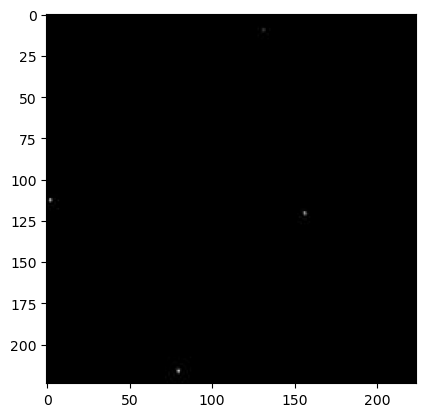

In [230]:
# Retrieve the file path and label from the DataFrame using the class index and the index within the class
try:
    file_path = nan_df.iloc[0]['file']
    print(file_path)

    # Read the image using OpenCV
    img = cv.imread(os.path.join(path, file_path))

    # Display the image with keypoints
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.show()
except IndexError:
    print('No nan rows to be shown')

In [231]:
df = df.dropna()

In [232]:
df.isna().sum()

file                0
label               0
split               0
label_num           0
sift_descriptors    0
sift_kp             0
dtype: int64

Cortinarius/Cortinarius_original_501_gpwKRQFfLIw.jpg_2bfadb73-c37c-4649-b8d6-949e7b67d61b.jpg


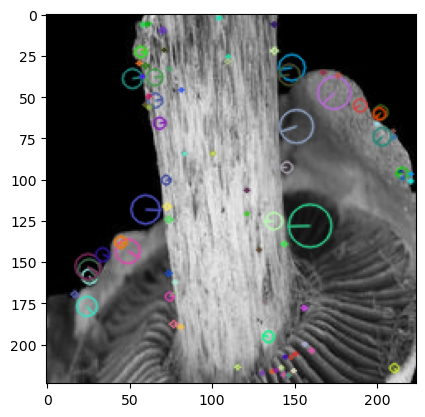

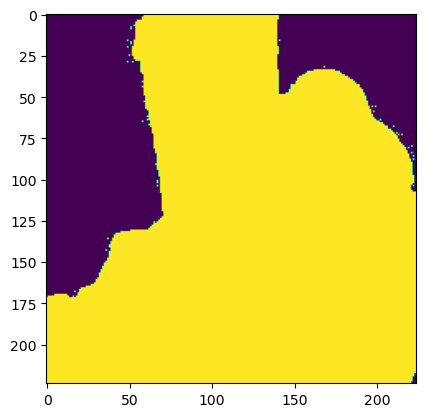

In [233]:
# Image index and class index
idx = 6

# Retrieve the file path and label from the DataFrame using the class index and the index within the class
file_path = df.iloc[idx]['file']
print(file_path)

# Read the image using OpenCV
img = cv.imread(os.path.join(path, file_path))

# Convert the image to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Draw keypoints on the image using OpenCV
img_with_kp = cv.drawKeypoints(gray, df.iloc[idx]['sift_kp'], img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.imshow(cv.cvtColor(img_with_kp, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.show()

# Create a mask where pixel intensity is greater than 10
mask = (gray > 10).astype(np.uint8)

# Display the mask image
plt.imshow(mask)
plt.show()

### 3. Making the Codebook <a class="anchor" id="third-bullet"></a>

In [234]:
# List holding sift descriptors for training the unsupervised clustering
sift_descriptors = [item for sublist in df[df['split'] == 'train']['sift_descriptors'] for item in sublist]
scaler_des = StandardScaler()
sift_descriptors = scaler_des.fit_transform(sift_descriptors)

Fitting KMeans: 100%|██████████| 9/9 [00:22<00:00,  2.46s/n_clusters]


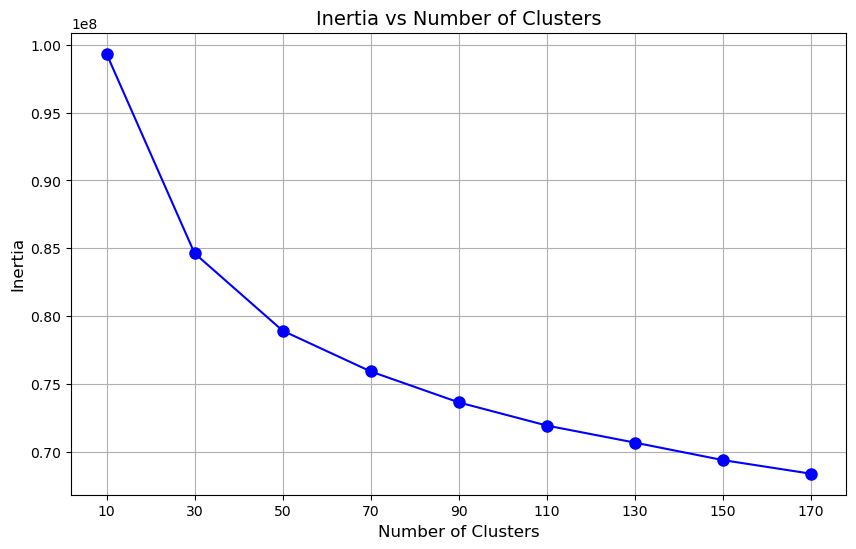

In [235]:
# List to hold inertia values for better visualization
inertia_values = []

# Iterate over cluster sizes
for i in tqdm(range(10, 190, 20), desc="Fitting KMeans", unit="n_clusters"):
    km = MiniBatchKMeans(n_clusters=i, batch_size=256*8, n_init=20, max_iter=100, random_state=42)
    km.fit(sift_descriptors)
    inertia_values.append(km.inertia_)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(10, 190, 20), inertia_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('Inertia vs Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(range(10, 190, 20))
plt.grid(True)
plt.show()

In [236]:
print(len(sift_descriptors))
print(len(sift_descriptors[0]))

1019808
128


In [237]:
def cluster(k, des_list, model='KMeans'):
    if model == 'KMeans':
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, n_init=10, max_iter=100, random_state=42)
        # np.random.shuffle(descriptor_list)
        for i in tqdm(range(kmeans.n_init), desc="KMeans Init", position=0, leave=True):
            kmeans.fit(des_list)
        kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(np.float32)
        # kmeans.predict(des_list[:].reshape(-1, 1))
        return kmeans
    if model == 'GaussianMixture':
        gm = GaussianMixture(n_components=k, random_state=42, n_init=10, max_iter=100, init_params='kmeans')
        np.random.shuffle(des_list)
        for i in tqdm(range(gm.n_init), desc="GaussianMixture Init", position=0, leave=True):
            gm.fit(des_list[::2])
        return gm
        
    
num_clusters = 50
visual_words = cluster(k=num_clusters, des_list=sift_descriptors, model='KMeans')

KMeans Init: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


### 4. Normalization  <a class="anchor" id="fourth-bullet"></a>

In [238]:
def get_bovw_histograms(df, model, num_clusters, normalizer_type = 'StandardScaler'):
    histograms = []  # List to store histograms for each image
    
    for img_descriptors in df['sift_descriptors']:
        histogram = np.zeros(num_clusters)  # Initialize histogram
        img_descriptors = scaler_des.transform(img_descriptors)
        visual_word_indices = model.predict(img_descriptors)  # Predict cluster indices
        for ind in visual_word_indices:
            histogram[ind] += 1  # Increment cluster index counts
        histograms.append(histogram)  # Append the histogram

    if normalizer_type == 'StandardScaler':
        scaler_histo = StandardScaler()
        histograms = list(scaler_histo.fit_transform(histograms))
    elif normalizer_type == 'l2':
        scaler_histo = Normalizer('l2')
        histograms = list(scaler_histo.fit_transform(histograms))
    
    # Add histograms as a new column in the DataFrame
    df = df.copy()
    if 'bovw_histograms' in df.columns:
        df = df.drop('bovw_histograms', axis=1)
    df.loc[:, 'bovw_histograms'] = histograms
    return df

In [239]:
def get_features(df):
    df = df.copy()
    df.loc[:, 'features'] = df.loc[:, 'bovw_histograms']
    return df

In [240]:
def get_matrixs(df, split):
    X = np.vstack(df[df['split'].isin(split)]['features'].values)
    y = np.array(df[df['split'].isin(split)]['label_num'])
    return X, y

Normalizer:  StandardScaler
Accuracy (SVM): 23.33%
Accuracy (KNN): 24.00%
Normalizer:  l2
Accuracy (SVM): 24.17%
Accuracy (KNN): 28.33%
Normalizer:  None
Accuracy (SVM): 9.67%
Accuracy (KNN): 26.50%


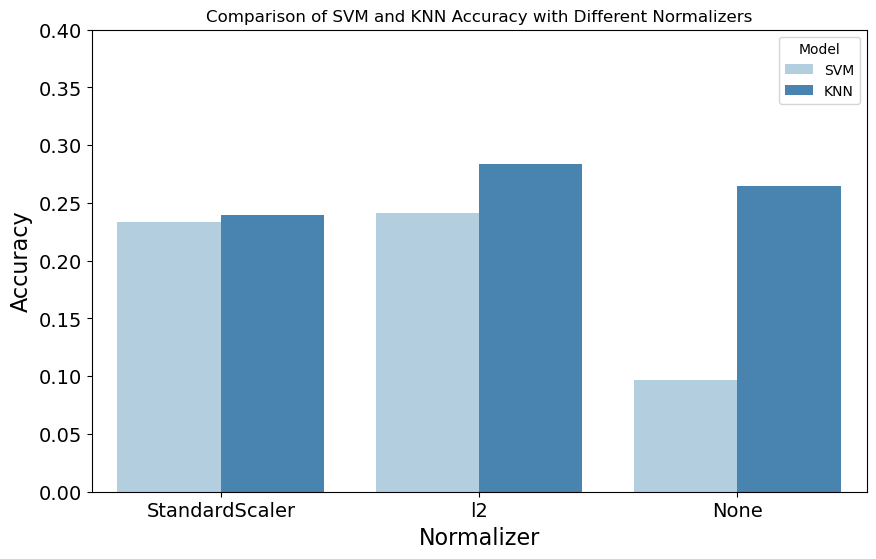

In [241]:
if full:
    norms = ['StandardScaler', 'l2', 'None']
    svm_accuracies = []
    knn_accuracies = []

    for norm in norms:
        print('Normalizer: ', norm)
        data = get_bovw_histograms(df, visual_words, num_clusters, normalizer_type=norm)
        data = get_features(data)
        X_train, y_train = get_matrixs(data, ['train'])
        X_val, y_val = get_matrixs(data, ['val'])

        svm = SVC(decision_function_shape='ovr', kernel='rbf', C=1.0, gamma=0.2)
        svm.fit(X_train, y_train)

        y_pred_val = svm.predict(X_val)
        accuracy_svm = accuracy_score(y_val, y_pred_val)
        print(f"Accuracy (SVM): {accuracy_svm * 100:.2f}%")

        knn = KNeighborsClassifier(n_neighbors=7)
        knn.fit(X_train, y_train)

        y_pred_val = knn.predict(X_val)
        accuracy_knn = accuracy_score(y_val, y_pred_val)
        print(f"Accuracy (KNN): {accuracy_knn * 100:.2f}%")

        svm_accuracies.append(accuracy_svm)
        knn_accuracies.append(accuracy_knn)

    # Create a DataFrame for easier plotting
    accuracy_df = pd.DataFrame({
        'Normalizer': norms * 2,  # Repeat for SVM and KNN
        'Accuracy': svm_accuracies + knn_accuracies,  # Combine SVM and KNN accuracies
        'Model': ['SVM'] * len(svm_accuracies) + ['KNN'] * len(knn_accuracies)  # Label the model
    })

    # Plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Normalizer', y='Accuracy', hue='Model', data=accuracy_df, palette='Blues')

    # Add labels and title
    plt.title('Comparison of SVM and KNN Accuracy with Different Normalizers')
    plt.xlabel('Normalizer', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 0.4)  # Set y-axis limits to [0, 1] for accuracy (0% to 100%)
    plt.show()

In [242]:
df = get_bovw_histograms(df, visual_words, num_clusters, normalizer_type='l2')
df = get_features(df)
X_train, y_train = get_matrixs(df, ['train'])
X_val, y_val = get_matrixs(df, ['val'])

[2, 4, 8, 16]
[0.18284341 0.08588466]


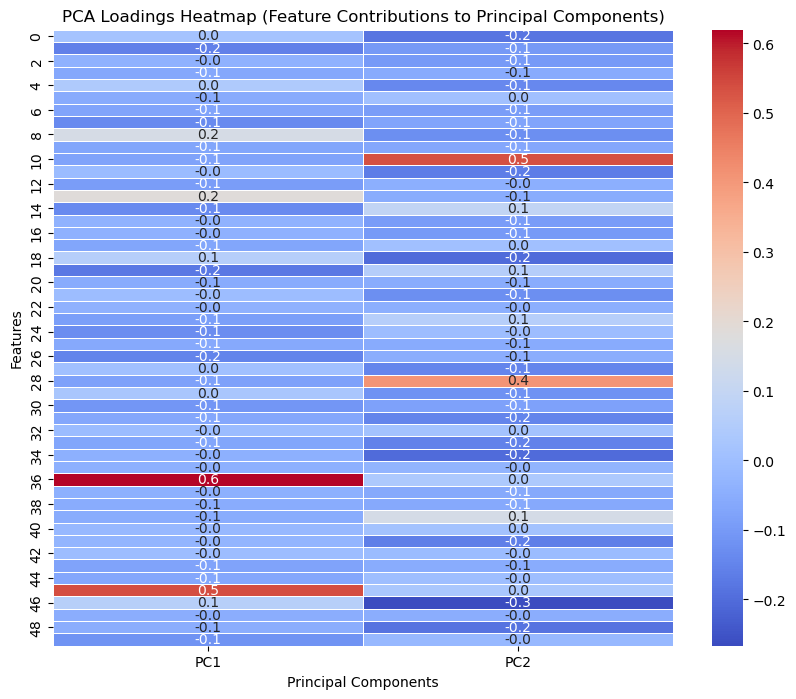

Accuracy (KNN): 11.17%
[0.18284341 0.08588466 0.08189867 0.05700249]


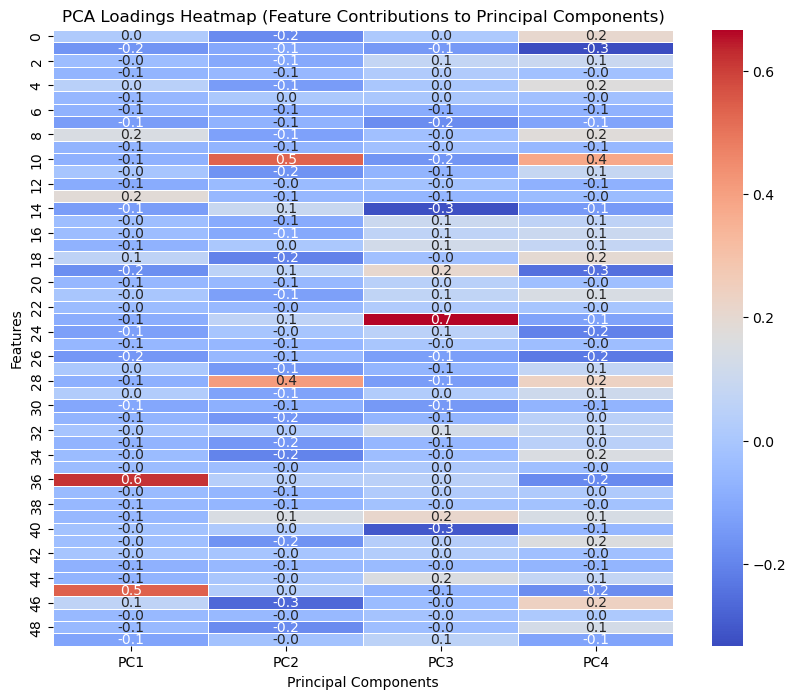

Accuracy (KNN): 16.00%
[0.18284341 0.08588466 0.08189867 0.05700249 0.04179874 0.03802838
 0.03607243 0.02902931]


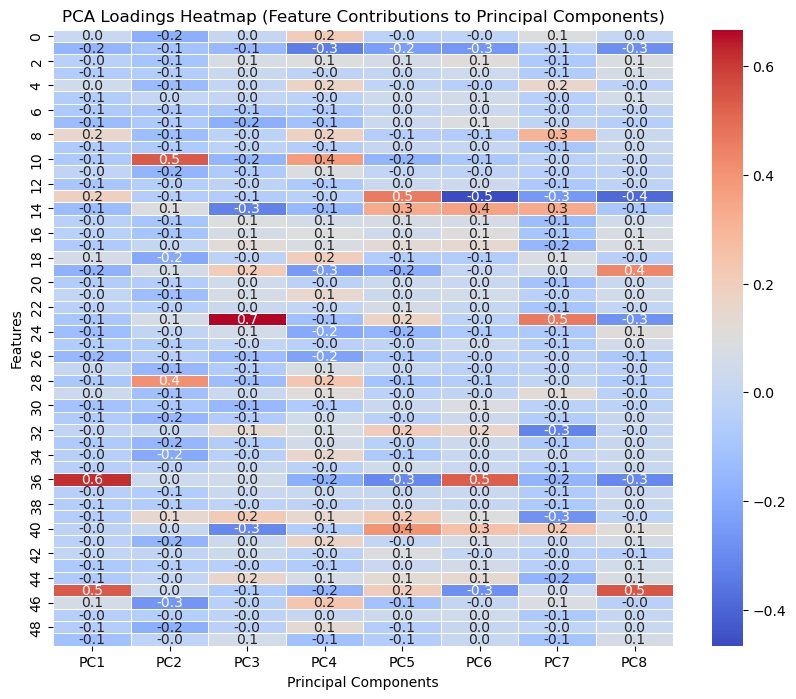

Accuracy (KNN): 19.50%
[0.18284341 0.08588466 0.08189867 0.05700249 0.04179874 0.03802838
 0.03607243 0.02902931 0.0287269  0.02518162 0.02203109 0.01942232
 0.01867283 0.0180961  0.01555496 0.01452141]


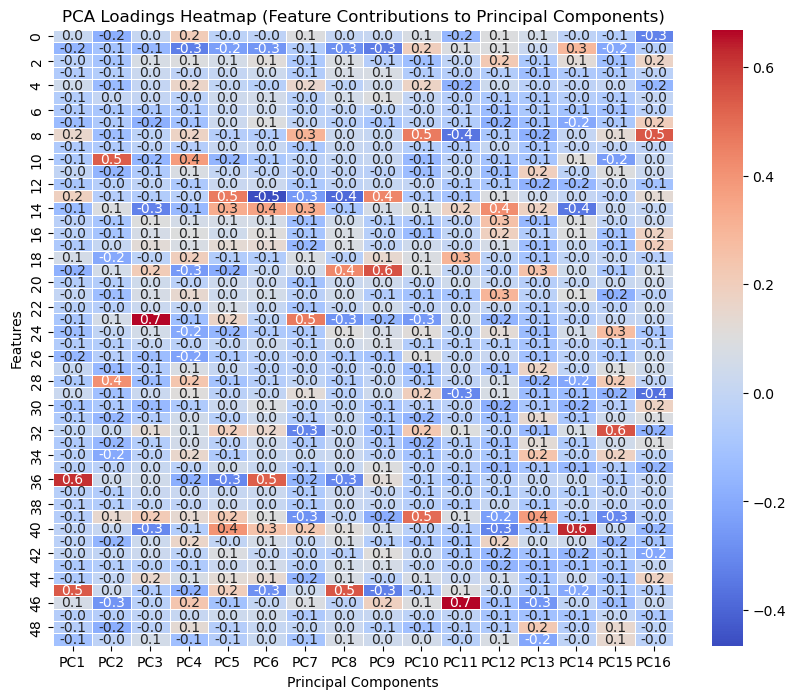

Accuracy (KNN): 21.83%


In [243]:
if full:
    ns = list(2**np.arange(1, 5))
    print(ns)

    for n in ns:
        pca = PCA(n_components=n)
        pca.fit(X_train)

        explained_variance = pca.explained_variance_ratio_
        print(explained_variance)

        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)

        loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

        plt.figure(figsize=(10, 8))
        sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
        plt.title('PCA Loadings Heatmap (Feature Contributions to Principal Components)')
        plt.xlabel('Principal Components')
        plt.ylabel('Features')
        plt.show()

        knn = KNeighborsClassifier(n_neighbors=7)
        knn.fit(X_train_pca, y_train)

        y_pred_val = knn.predict(X_val_pca)
        accuracy_knn = accuracy_score(y_val, y_pred_val)
        print(f"Accuracy (KNN): {accuracy_knn * 100:.2f}%")

### 6. Considering the Role of Color <a class="anchor" id="sixth-bullet"></a>

In [244]:
def calculate_color_histograms(im, mask, bins=64):
    blue_hist = cv.calcHist([im], [0], mask, [bins], [0, 256])
    green_hist = cv.calcHist([im], [1], mask, [bins], [0, 256])
    red_hist = cv.calcHist([im], [2], mask, [bins], [0, 256])

    blue_hist_norm = cv.normalize(blue_hist, blue_hist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    green_hist_norm = cv.normalize(green_hist, green_hist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    red_hist_norm = cv.normalize(red_hist, red_hist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

    color_v = np.append(blue_hist_norm, green_hist_norm)
    color_v = np.append(color_v, red_hist_norm)
    return color_v.ravel().flatten()

def get_color_features(data_df, path, bins=64):

    if 'color_histograms' in data_df.columns:
        data_df = data_df.drop('color_histograms', axis=1)

    def process_row(row):
        file, label = row['file'], row['label']
        im = cv.imread(os.path.join(path, file))
        
        gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        mask = (gray > 10).astype(np.uint8)

        color_v = calculate_color_histograms(im, mask, bins)
        row['color_histograms'] = color_v

        return row

    tqdm.pandas()
    
    data_df = data_df.progress_apply(process_row, axis=1)

    return data_df

def get_features(df):
    joint_features = []
    words_histograms = df['bovw_histograms']
    color_histograms = df['color_histograms']

    for s, c in zip(words_histograms, color_histograms):
        joint = np.append(s, c)
        joint_features.append(joint)

    df = df.copy()
    if 'features' in df.columns:
        df = df.drop(columns=['features'])
    df.loc[:, 'features'] = joint_features
    return df

In [245]:
if full:
    n_bins = list(2**np.arange(3,8))
    svm_accuracies = []
    knn_accuracies = []
    print(n_bins)

    for n in n_bins:
        data = get_color_features(df, path, n)
        data = get_features(data)

        X_train, y_train = get_matrixs(data, ['train'])
        X_val, y_val = get_matrixs(data, ['val'])

        print(X_train.shape)

        pca = PCA(n_components=n)
        pca.fit(X_train)

        explained_variance = pca.explained_variance_ratio_
        print(explained_variance)

        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)

        svm = SVC(decision_function_shape='ovr', kernel='rbf', C=1.0, gamma=0.1)
        svm.fit(X_train_pca, y_train)

        y_pred_val = svm.predict(X_val_pca)
        accuracy_svm = accuracy_score(y_val, y_pred_val)
        print(f"Accuracy (SVM): {accuracy_svm * 100:.2f}%")

        knn = KNeighborsClassifier(n_neighbors=7)
        knn.fit(X_train_pca, y_train)

        y_pred_val = knn.predict(X_val_pca)
        accuracy_knn = accuracy_score(y_val, y_pred_val)
        print(f"Accuracy (KNN): {accuracy_knn * 100:.2f}%")

        svm_accuracies.append(accuracy_svm)
        knn_accuracies.append(accuracy_knn)

[8, 16, 32, 64, 128]


100%|██████████| 11999/11999 [00:17<00:00, 699.24it/s]


(10799, 74)
[0.27476301 0.14909476 0.06772513 0.06569964 0.06061896 0.0399626
 0.03188202 0.02516482]
Accuracy (SVM): 28.00%
Accuracy (KNN): 43.00%


100%|██████████| 11999/11999 [00:17<00:00, 695.04it/s]


(10799, 98)
[0.26465696 0.16167245 0.08918015 0.06184385 0.05729908 0.04125405
 0.03141092 0.02092187 0.01997015 0.01907443 0.01600407 0.01438062
 0.01294158 0.01222448 0.00960084 0.00935126]
Accuracy (SVM): 34.17%
Accuracy (KNN): 49.50%


100%|██████████| 11999/11999 [00:17<00:00, 690.65it/s]


(10799, 146)
[0.25968807 0.17762086 0.10373706 0.06079027 0.05543257 0.04294064
 0.03218522 0.02140909 0.02064139 0.0183612  0.01487844 0.01331103
 0.01232128 0.01026799 0.00914374 0.00883685 0.0083928  0.00782831
 0.00720034 0.00587397 0.00541608 0.00505788 0.00461535 0.00428681
 0.00406133 0.00377678 0.00373425 0.00323837 0.00290331 0.0027817
 0.0026844  0.00241737]
Accuracy (SVM): 44.50%
Accuracy (KNN): 51.67%


100%|██████████| 11999/11999 [00:17<00:00, 697.81it/s]


(10799, 242)
[0.26060278 0.19034473 0.10536312 0.06033965 0.05507771 0.04535562
 0.03173397 0.02256965 0.02099185 0.0178149  0.01520394 0.01375943
 0.01233283 0.0102965  0.00951106 0.00813693 0.00788239 0.00729598
 0.0058096  0.00520918 0.00498678 0.00465598 0.00434613 0.00382782
 0.00374626 0.00327193 0.00283855 0.00278802 0.0027047  0.00240922
 0.00230075 0.00214373 0.00200476 0.0019363  0.00166431 0.00162233
 0.00158027 0.0015106  0.00134364 0.00131324 0.00127139 0.00121368
 0.00116782 0.00114203 0.00104534 0.00098616 0.00095828 0.0009181
 0.00090098 0.00086346 0.00080545 0.00078845 0.00074105 0.00070912
 0.00068808 0.00064133 0.00061723 0.00061439 0.00060841 0.00058819
 0.00056926 0.00053464 0.00051192 0.00049979]
Accuracy (SVM): 58.67%
Accuracy (KNN): 53.67%


100%|██████████| 11999/11999 [00:17<00:00, 695.28it/s]


(10799, 434)
[2.58865884e-01 1.97508699e-01 1.04802158e-01 5.84954392e-02
 5.56914135e-02 4.84007899e-02 3.14747014e-02 2.38929316e-02
 2.16926564e-02 1.75300520e-02 1.56576726e-02 1.46399733e-02
 1.19534126e-02 1.03416029e-02 9.80386130e-03 7.82941983e-03
 7.79173284e-03 7.23987284e-03 5.67071082e-03 5.11404434e-03
 4.64956163e-03 4.03937393e-03 3.83172158e-03 3.71353672e-03
 3.26312678e-03 2.76469067e-03 2.72610035e-03 2.65017303e-03
 2.39372504e-03 2.15873648e-03 2.04624291e-03 1.94117690e-03
 1.65922864e-03 1.57638240e-03 1.54228630e-03 1.47197956e-03
 1.36642189e-03 1.29522029e-03 1.25589092e-03 1.12942638e-03
 1.04499936e-03 9.85430868e-04 9.48508834e-04 8.84824072e-04
 8.46290284e-04 8.05200908e-04 7.71119286e-04 7.42741893e-04
 6.96491121e-04 6.70830276e-04 6.58042959e-04 6.22845693e-04
 6.17322970e-04 5.81788411e-04 5.64187990e-04 5.30419737e-04
 5.07095815e-04 4.94400006e-04 4.79585853e-04 4.72482885e-04
 4.37184637e-04 4.23305263e-04 4.16504547e-04 4.05710644e-04
 3.82612571

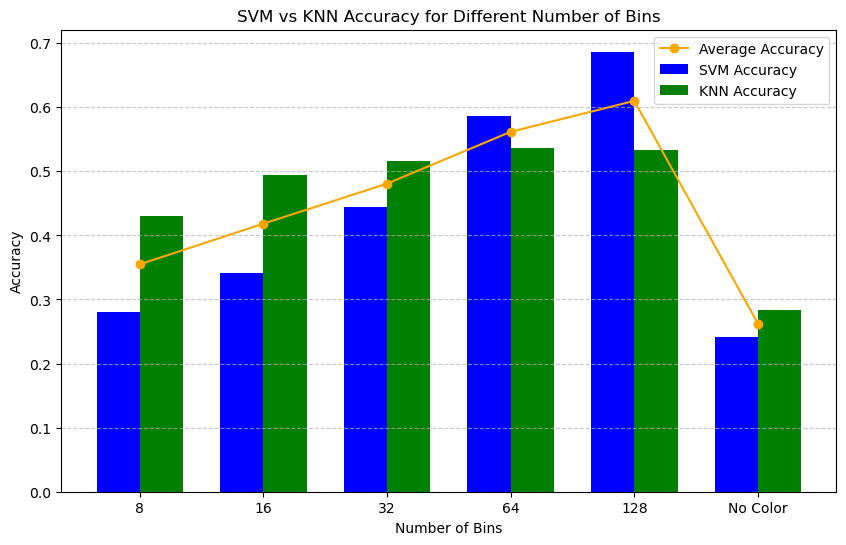

In [246]:
if full:
    last_acc_svm = 0.2417
    last_acc_knn = 0.2833

    label_bins = n_bins.copy()
    n_bins.append(100)

    label_bins.append('No Color')
    svm_accuracies.append(last_acc_svm)
    knn_accuracies.append(last_acc_knn)

    average_accuracies = [(svm + knn) / 2 for svm, knn in zip(svm_accuracies, knn_accuracies)]

    plt.figure(figsize=(10, 6))

    # Width of each bar
    bar_width = 0.35

    # Positions of bars on the x-axis
    x_indices = np.arange(len(n_bins))

    # Create bars for SVM and KNN
    plt.bar(x_indices - bar_width/2, svm_accuracies, width=bar_width, label='SVM Accuracy', color='blue')
    plt.bar(x_indices + bar_width/2, knn_accuracies, width=bar_width, label='KNN Accuracy', color='green')

    # Plot the average line
    plt.plot(x_indices, average_accuracies, label='Average Accuracy', color='orange', marker='o', linestyle='-')

    # Set tick positions and labels
    plt.xticks(ticks=x_indices, labels=label_bins)

    # Add labels and title
    plt.xlabel('Number of Bins')
    plt.ylabel('Accuracy')
    plt.title('SVM vs KNN Accuracy for Different Number of Bins')
    plt.legend()

    # Display the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add gridlines for better readability
    plt.show()

In [247]:
if full:
    n_bins = list(np.arange(64,129, 32))
    svm_accuracies = []
    knn_accuracies = []
    print(n_bins)

    for n in n_bins:
        # Step 1: Generate features
        data = get_color_features(df, path, n)  # Assuming this generates features
        data = get_features(data)  # Additional feature engineering

        # Step 2: Split into train/val datasets
        X_train, y_train = get_matrixs(data, ['train'])
        X_val, y_val = get_matrixs(data, ['val'])

        # Step 3: Select first 50 features
        X_train_first_50 = X_train[:, :50]  # First 50 features
        X_val_first_50 = X_val[:, :50]  # First 50 features

        # Step 4: Apply PCA to features 51 onwards
        X_train_selected = X_train[:, 50:]  # Features 51 and onwards (0-based index)
        X_val_selected = X_val[:, 50:]

        pca = PCA()  # Keep all components initially to analyze explained variance
        X_train_pca = pca.fit_transform(X_train_selected)
        X_val_pca = pca.transform(X_val_selected)

        # Print explained variance ratio for debug (optional)
        explained_variance = pca.explained_variance_ratio_
        print(f"Explained Variance Ratio for n_bins={n}: {explained_variance}")

        # Optional: Reduce the number of PCA components (example: keep top 10 PCs)
        pca = PCA(n_components=min(48, X_train_pca.shape[1]))  # Keep top 10 PCs
        X_train_pca = pca.fit_transform(X_train_selected)
        X_val_pca = pca.transform(X_val_selected)

        # Step 5: Combine the original 50 features and PCA features
        X_train_combined = np.hstack((X_train_first_50, X_train_pca))  # Concatenate along axis 1
        X_val_combined = np.hstack((X_val_first_50, X_val_pca))

        print(X_train_combined.shape)

        # Step 6: Train and evaluate SVM
        svm = SVC(decision_function_shape='ovr', kernel='rbf', C=1.0, gamma=0.1)
        svm.fit(X_train_combined, y_train)

        y_pred_val_svm = svm.predict(X_val_combined)
        accuracy_svm = accuracy_score(y_val, y_pred_val_svm)
        print(f"Accuracy (SVM) for n_bins={n}: {accuracy_svm * 100:.2f}%")
        svm_accuracies.append(accuracy_svm)

        # Step 7: Train and evaluate KNN
        knn = KNeighborsClassifier(n_neighbors=7)
        knn.fit(X_train_combined, y_train)

        y_pred_val_knn = knn.predict(X_val_combined)
        accuracy_knn = accuracy_score(y_val, y_pred_val_knn)
        print(f"Accuracy (KNN) for n_bins={n}: {accuracy_knn * 100:.2f}%")
        knn_accuracies.append(accuracy_knn)

    # Final Results
    print("SVM Accuracies:", [f"{acc * 100:.2f}%" for acc in svm_accuracies])
    print("KNN Accuracies:", [f"{acc * 100:.2f}%" for acc in knn_accuracies])


[64, 96, 128]


100%|██████████| 11999/11999 [00:16<00:00, 730.71it/s]


Explained Variance Ratio for n_bins=64: [2.68024293e-01 1.96655225e-01 1.08744635e-01 6.22892769e-02
 5.69337372e-02 4.68706293e-02 3.27903993e-02 2.33163742e-02
 2.16776971e-02 1.84183682e-02 1.57031986e-02 1.41783749e-02
 1.27386162e-02 1.06083796e-02 9.81507487e-03 8.40224503e-03
 8.13490817e-03 7.53153586e-03 5.96320974e-03 5.37109867e-03
 4.81319070e-03 4.47894290e-03 3.95782251e-03 3.87443463e-03
 3.37951111e-03 2.91163292e-03 2.84922821e-03 2.49841050e-03
 2.23961594e-03 2.12051358e-03 2.02376618e-03 1.70777839e-03
 1.67208589e-03 1.56694318e-03 1.36203751e-03 1.32182531e-03
 1.21453669e-03 1.07489335e-03 1.01454758e-03 9.46067909e-04
 9.02804342e-04 8.25664508e-04 7.73420161e-04 7.12432863e-04
 6.54097418e-04 6.29485257e-04 5.88897737e-04 5.54659201e-04
 5.22645507e-04 4.77434223e-04 4.50763143e-04 4.28039822e-04
 4.00831432e-04 3.93030594e-04 3.74053753e-04 3.32254669e-04
 3.18454980e-04 3.05964591e-04 2.89182920e-04 2.80104022e-04
 2.62092847e-04 2.56547665e-04 2.34372050e-04

100%|██████████| 11999/11999 [00:16<00:00, 708.56it/s]


Explained Variance Ratio for n_bins=96: [2.65572531e-01 1.95460305e-01 1.08821226e-01 6.14498181e-02
 5.67960664e-02 4.73385870e-02 3.30574585e-02 2.37341607e-02
 2.15787042e-02 1.83194950e-02 1.57085870e-02 1.42966535e-02
 1.27298653e-02 1.04850130e-02 9.92020725e-03 8.28023423e-03
 8.09980377e-03 7.52866376e-03 5.92309372e-03 5.36062696e-03
 4.81230131e-03 4.38900008e-03 3.99198375e-03 3.86859986e-03
 3.37372507e-03 2.91281892e-03 2.86624987e-03 2.49137958e-03
 2.26049459e-03 2.15244989e-03 2.03335727e-03 1.71719156e-03
 1.66578347e-03 1.57956361e-03 1.38584008e-03 1.34262576e-03
 1.23695285e-03 1.09300526e-03 1.02668191e-03 9.66912950e-04
 9.29088877e-04 8.51753305e-04 8.00789760e-04 7.36227113e-04
 6.92206490e-04 6.52924411e-04 6.04941866e-04 5.91522190e-04
 5.48683971e-04 4.96259332e-04 4.86926911e-04 4.41022856e-04
 4.29990365e-04 4.15900528e-04 3.90810402e-04 3.61604512e-04
 3.52077219e-04 3.21730338e-04 3.16859386e-04 3.00901008e-04
 2.79613694e-04 2.73451148e-04 2.60540162e-04

100%|██████████| 11999/11999 [00:17<00:00, 705.34it/s]


Explained Variance Ratio for n_bins=128: [2.62844274e-01 2.01034783e-01 1.06611236e-01 5.95240828e-02
 5.66934563e-02 4.92788681e-02 3.20334711e-02 2.43120714e-02
 2.20797506e-02 1.78502736e-02 1.59382477e-02 1.48715052e-02
 1.21643675e-02 1.05129081e-02 9.97352289e-03 7.96662272e-03
 7.93055569e-03 7.36353779e-03 5.76160260e-03 5.20305163e-03
 4.71565712e-03 4.10243408e-03 3.89709155e-03 3.74586951e-03
 3.28920318e-03 2.77194915e-03 2.75432529e-03 2.44808039e-03
 2.19225959e-03 2.09841957e-03 1.98239947e-03 1.68252764e-03
 1.58757144e-03 1.53788081e-03 1.36377591e-03 1.32095413e-03
 1.21004590e-03 1.06122097e-03 1.00328044e-03 9.51703821e-04
 9.01764882e-04 8.33781643e-04 7.86387509e-04 7.18696174e-04
 6.71946901e-04 6.33839314e-04 5.95574973e-04 5.75980963e-04
 5.40344019e-04 4.81809039e-04 4.79403300e-04 4.35432834e-04
 4.24767451e-04 4.14642582e-04 3.81908222e-04 3.55241024e-04
 3.35179612e-04 3.15648332e-04 3.08406222e-04 2.95578453e-04
 2.73760618e-04 2.69751060e-04 2.54483748e-0

SVM Accuracies: ['59.00%', '61.17%', '67.33%']
KNN Accuracies: ['53.83%', '52.50%', '52.50%']


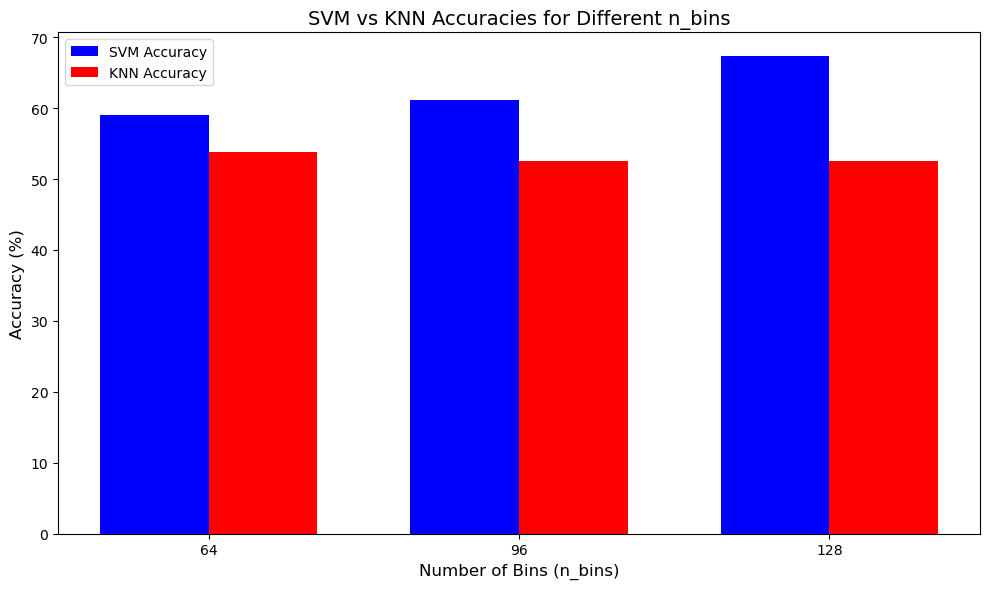

In [248]:
if full:
    # Final Results
    print("SVM Accuracies:", [f"{acc * 100:.2f}%" for acc in svm_accuracies])
    print("KNN Accuracies:", [f"{acc * 100:.2f}%" for acc in knn_accuracies])

    # Plotting bar plot
    bar_width = 0.35  # Bar width for side-by-side bars
    index = np.arange(len(n_bins))  # The label locations for the bins

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Bar plot for SVM
    plt.bar(index - bar_width / 2, [acc * 100 for acc in svm_accuracies], bar_width, label='SVM Accuracy', color='b')

    # Bar plot for KNN
    plt.bar(index + bar_width / 2, [acc * 100 for acc in knn_accuracies], bar_width, label='KNN Accuracy', color='r')

    # Labels and title
    plt.title('SVM vs KNN Accuracies for Different n_bins', fontsize=14)
    plt.xlabel('Number of Bins (n_bins)', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(index, n_bins)  # Set x-ticks to match the n_bins values
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

In [249]:
df = get_color_features(df, path, 128)  # Assuming this generates features

def apply_pca_color_histograms(df, n=48):
    histograms = np.array(df['color_histograms'].tolist())
    pca = PCA(n_components=48)
    pca_result = pca.fit_transform(histograms)

    df = df.drop(columns=['color_histograms']).copy()
    df.loc[:, 'color_histograms'] = list(pca_result)
    return df

df = apply_pca_color_histograms(df, 48)

100%|██████████| 11999/11999 [00:16<00:00, 730.72it/s]


In [250]:
df = get_features(df)

X_train, y_train = get_matrixs(df, ['train'])
X_val, y_val = get_matrixs(df, ['val'])
X_test, y_test = get_matrixs(df, ['test'])

In [251]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(10799, 98) (10799,)
(600, 98) (600,)
(600, 98) (600,)


### 5. Classifier <a class="anchor" id="fourth-bullet"></a>

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best parameters found by GridSearchCV: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 78.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        50
           1       0.85      0.78      0.81        50
           2       0.66      0.76      0.70        50
           3       0.76      0.64      0.70        50
           4       0.86      0.84      0.85        50
           5       0.79      0.90      0.84        50
           6       0.77      0.96      0.86        50
           7       0.78      0.86      0.82        50
           8       0.74      0.64      0.69        50
           9       0.88      0.86      0.87        50
          10       0.71      0.74      0.73        50
          11       0.93      0.80      0.86        50

    accuracy                           0.79       600
   macro avg       0.79      0.79    

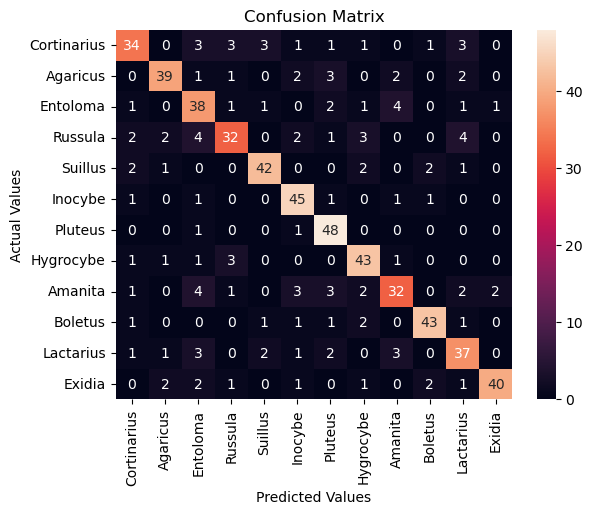

In [252]:
# Hyperparameters grid for GridSearch
param_grid = {
    'n_neighbors': [3, 5, 7, 9],           # Number of neighbors
    'weights': ['uniform', 'distance'],   # Weighting function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Initialize the SVM classifier
knn = KNeighborsClassifier()
    
# Perform grid search with 5-fold cross-validation
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)

# Train the classifier using GridSearchCV
grid_search_knn.fit(X_train, y_train)
    
# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:", grid_search_knn.best_params_)

# Get the best model from the grid search
best_knn = grid_search_knn.best_estimator_
    
# Use the trained model to predict the labels of the test set
y_pred_val_knn = best_knn.predict(X_val)
    
# Calculate accuracy
accuracy_knn = accuracy_score(y_val, y_pred_val_knn)
print(f"Accuracy: {accuracy_knn * 100:.2f}%")

# Confusion Matrix
cf_matrix_knn = confusion_matrix(y_val, y_pred_val_knn)
ax = sns.heatmap(cf_matrix_knn, annot=True, xticklabels=classes, yticklabels=classes)
ax.set(xlabel="Predicted Values", ylabel="Actual Values", title='Confusion Matrix')

# Classification Report
result_knn = classification_report(y_val, y_pred_val_knn)
print('Classification Report:')
print(result_knn)

Fitting 4 folds for each of 45 candidates, totalling 180 fits
Best parameters found by GridSearchCV: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 82.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.69        50
           1       0.76      0.90      0.83        50
           2       0.80      0.82      0.81        50
           3       0.77      0.80      0.78        50
           4       0.79      0.82      0.80        50
           5       0.92      0.90      0.91        50
           6       0.92      0.90      0.91        50
           7       0.92      0.88      0.90        50
           8       0.85      0.80      0.82        50
           9       0.88      0.86      0.87        50
          10       0.82      0.72      0.77        50
          11       0.89      0.80      0.84        50

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weight

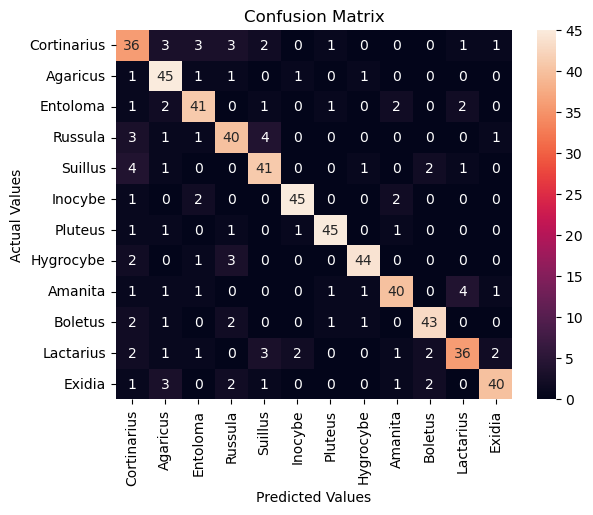

In [253]:
# Hyperparameters grid for GridSearch
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize the SVM classifier
svm = SVC(decision_function_shape='ovo')
    
# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=4, verbose=1, n_jobs=-1)
    
# Train the classifier using GridSearchCV
grid_search.fit(X_train, y_train)
    
# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
    
# Get the best model from the grid search
best_svm = grid_search.best_estimator_
    
# Use the trained model to predict the labels of the test set
y_pred_val_svm = best_svm.predict(X_val)
    
# Calculate accuracy
accuracy_svm = accuracy_score(y_val, y_pred_val_svm)
print(f"Accuracy: {accuracy_svm * 100:.2f}%")

# Confusion Matrix
cf_matrix_svm = confusion_matrix(y_val, y_pred_val_svm)
ax = sns.heatmap(cf_matrix_svm, annot=True, xticklabels=classes, yticklabels=classes)
ax.set(xlabel="Predicted Values", ylabel="Actual Values", title='Confusion Matrix')

# Classification Report
result_svm = classification_report(y_val, y_pred_val_svm)
print('Classification Report:')
print(result_svm)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found by GridSearchCV (Random Forest): {'max_depth': 30, 'n_estimators': 200}
Random Forest Accuracy: 68.00%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.56      0.55        50
           1       0.55      0.82      0.66        50
           2       0.60      0.60      0.60        50
           3       0.71      0.50      0.59        50
           4       0.82      0.72      0.77        50
           5       0.67      0.70      0.69        50
           6       0.89      0.84      0.87        50
           7       0.71      0.82      0.76        50
           8       0.61      0.56      0.58        50
           9       0.74      0.74      0.74        50
          10       0.60      0.52      0.56        50
          11       0.80      0.78      0.79        50

    accuracy                           0.68       600
   macro avg       

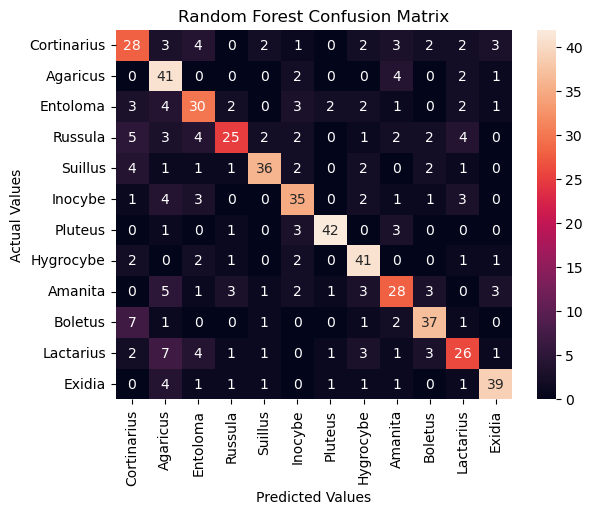

In [254]:
# Hyperparameters grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, verbose=1, n_jobs=-1)

# Train the classifier using GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV (Random Forest):", grid_search_rf.best_params_)

# Get the best model from the grid search
best_rf = grid_search_rf.best_estimator_

# Use the trained model to predict the labels of the test set
y_pred_val_rf = best_rf.predict(X_val)

# Calculate accuracy
accuracy_rf = accuracy_score(y_val, y_pred_val_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")

# Confusion Matrix
cf_matrix_rf = confusion_matrix(y_val, y_pred_val_rf)
ax = sns.heatmap(cf_matrix_rf, annot=True, xticklabels=classes, yticklabels=classes)
ax.set(xlabel="Predicted Values", ylabel="Actual Values", title='Random Forest Confusion Matrix')

# Classification Report
result_rf = classification_report(y_val, y_pred_val_rf)
print('Random Forest Classification Report:')
print(result_rf)

### Final Evaluation

In [255]:
X_train, y_train = get_matrixs(df, ['train', 'val'])
X_test, y_test = get_matrixs(df, ['test'])

Accuracy: 81.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78        50
           1       0.75      0.66      0.70        50
           2       0.75      0.76      0.75        50
           3       0.81      0.68      0.74        50
           4       0.85      0.92      0.88        50
           5       0.85      0.94      0.90        50
           6       0.86      0.98      0.92        50
           7       0.94      0.94      0.94        50
           8       0.83      0.88      0.85        50
           9       0.79      0.76      0.78        50
          10       0.69      0.70      0.69        50
          11       0.93      0.80      0.86        50

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



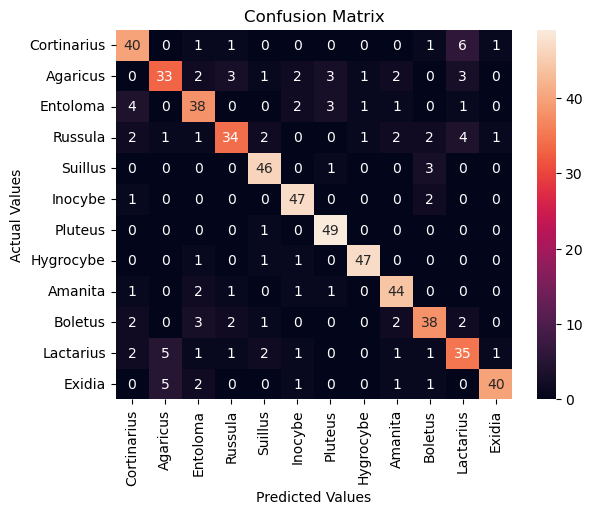

In [256]:
best_knn = KNeighborsClassifier(metric='manhattan', n_neighbors= 3, weights = 'distance')
best_knn.fit(X_train, y_train)

# Use the trained model to predict the labels of the test set
y_pred_test_knn = best_knn.predict(X_test)
    
# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_test_knn)
print(f"Accuracy: {accuracy_knn * 100:.2f}%")

# Confusion Matrix
cf_matrix_knn = confusion_matrix(y_test, y_pred_test_knn)
ax = sns.heatmap(cf_matrix_knn, annot=True, xticklabels=classes, yticklabels=classes)
ax.set(xlabel="Predicted Values", ylabel="Actual Values", title='Confusion Matrix')

# Classification Report
result_knn = classification_report(y_test, y_pred_test_knn)
print('Classification Report:')
print(result_knn)

Accuracy: 81.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78        50
           1       0.77      0.72      0.74        50
           2       0.83      0.70      0.76        50
           3       0.73      0.70      0.71        50
           4       0.87      0.90      0.88        50
           5       0.83      0.86      0.84        50
           6       0.92      0.94      0.93        50
           7       0.94      0.98      0.96        50
           8       0.86      0.84      0.85        50
           9       0.83      0.86      0.84        50
          10       0.78      0.78      0.78        50
          11       0.85      0.80      0.82        50

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



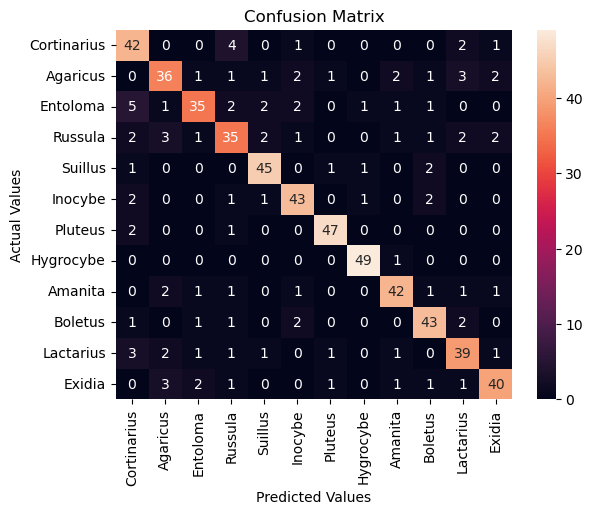

In [257]:
best_knn = SVC(C=10, gamma=0.1, kernel='rbf')
best_knn.fit(X_train, y_train)

# Use the trained model to predict the labels of the test set
y_pred_test_knn = best_knn.predict(X_test)
    
# Calculate accuracy
accuracy_svc = accuracy_score(y_test, y_pred_test_knn)
print(f"Accuracy: {accuracy_knn * 100:.2f}%")

# Confusion Matrix
cf_matrix_knn = confusion_matrix(y_test, y_pred_test_knn)
ax = sns.heatmap(cf_matrix_knn, annot=True, xticklabels=classes, yticklabels=classes)
ax.set(xlabel="Predicted Values", ylabel="Actual Values", title='Confusion Matrix')

# Classification Report
result_svc = classification_report(y_test, y_pred_test_knn)
print('Classification Report:')
print(result_svc)

Accuracy: 68.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.72      0.61        50
           1       0.60      0.60      0.60        50
           2       0.64      0.50      0.56        50
           3       0.71      0.44      0.54        50
           4       0.78      0.72      0.75        50
           5       0.74      0.78      0.76        50
           6       0.77      0.82      0.80        50
           7       0.74      0.92      0.82        50
           8       0.73      0.72      0.73        50
           9       0.61      0.70      0.65        50
          10       0.65      0.48      0.55        50
          11       0.75      0.82      0.78        50

    accuracy                           0.69       600
   macro avg       0.69      0.69      0.68       600
weighted avg       0.69      0.69      0.68       600



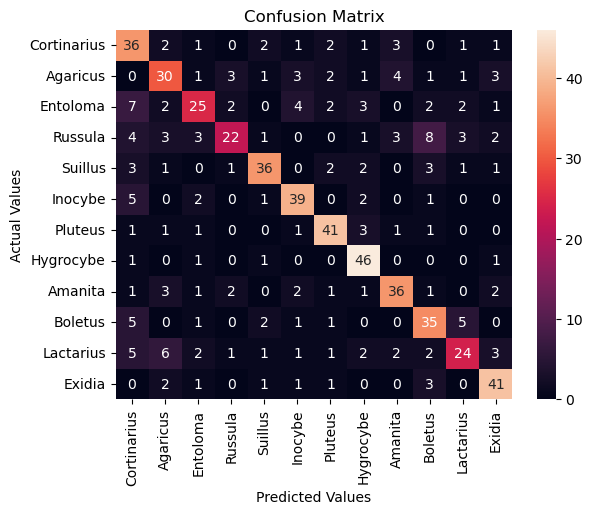

In [258]:
best_knn = RandomForestClassifier(max_depth= 30, n_estimators=200)
best_knn.fit(X_train, y_train)

# Use the trained model to predict the labels of the test set
y_pred_test_knn = best_knn.predict(X_test)
    
# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_test_knn)
print(f"Accuracy: {accuracy_rf * 100:.2f}%")

# Confusion Matrix
cf_matrix_knn = confusion_matrix(y_test, y_pred_test_knn)
ax = sns.heatmap(cf_matrix_knn, annot=True, xticklabels=classes, yticklabels=classes)
ax.set(xlabel="Predicted Values", ylabel="Actual Values", title='Confusion Matrix')

# Classification Report
result_rf = classification_report(y_test, y_pred_test_knn)
print('Classification Report:')
print(result_rf)

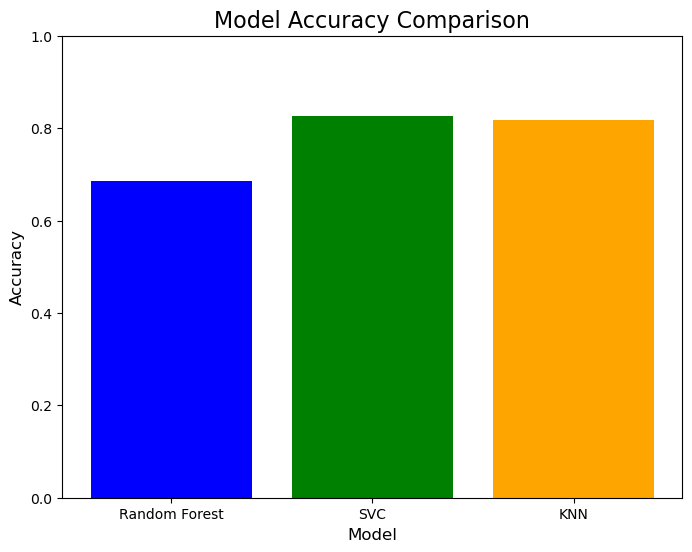

In [259]:
# Labels for the bar plot
models = ['Random Forest', 'SVC', 'KNN']
accuracies = [accuracy_rf, accuracy_svc, accuracy_knn]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])

# Add titles and labels
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Show the plot
plt.ylim(0, 1)
plt.show()

In [260]:
def get_query(X, y, l, query):
    print(query)
    y = np.array([num_to_label[cls] for cls in y])
    l = np.array([num_to_label[cls] for cls in l])
    X = np.array(X)
    imgs_files = X[y == query]
    labels = l[y == query]
    
    # Create a figure for displaying images
    plt.figure(figsize=(10, 5))

    cols = 10
    rows = int(np.ceil(len(imgs_files)/cols))

    # Loop through the image files and display them
    for i, (image_file, label) in enumerate(zip(imgs_files, labels)):
        img_path = os.path.join(path, image_file)
        img = mpimg.imread(img_path)
        
        # Create a subplot for each image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide axis
        plt.title(label)  # Optional: show image file name as title

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


Boletus


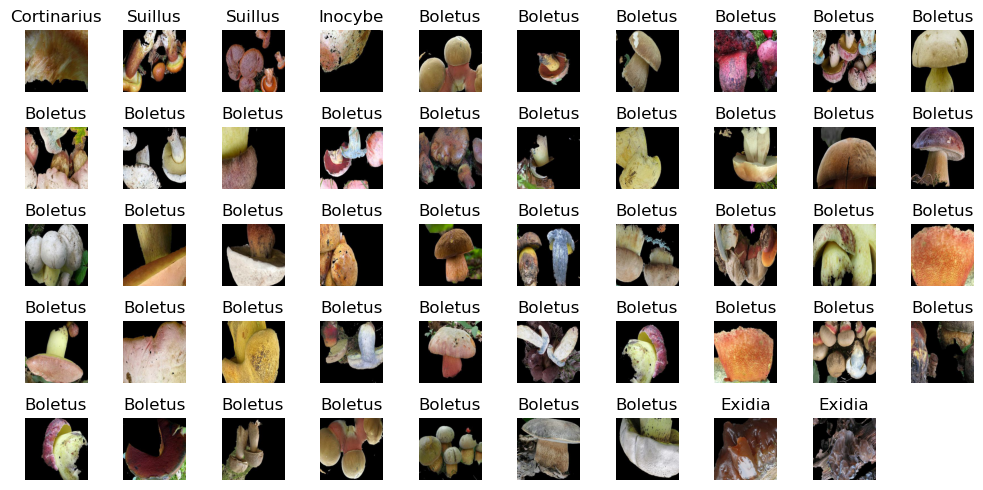

In [261]:
get_query(df[df['split'].isin(['val'])]['file'], y_pred_val_knn, y_val, 'Boletus')

Lactarius


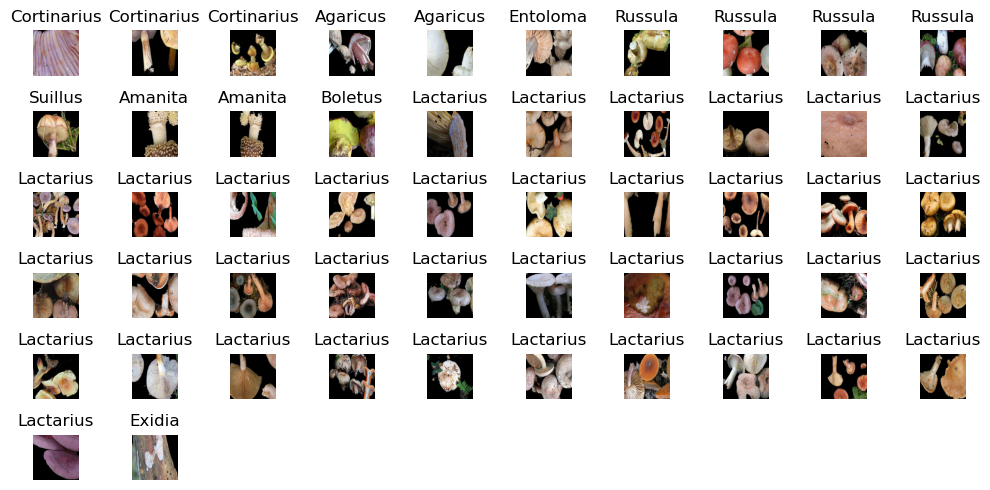

In [262]:
get_query(df[df['split'].isin(['val'])]['file'], y_pred_val_knn, y_val, 'Lactarius')

Boletus


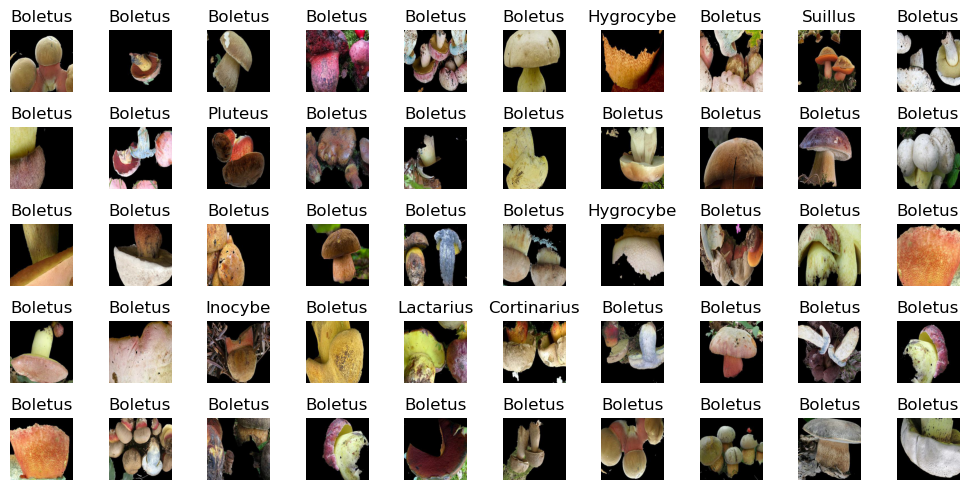

In [263]:
# for q in classes:
get_query(df[df['split'].isin(['val'])]['file'], y_val, y_pred_val_knn, 'Boletus')

Lactarius


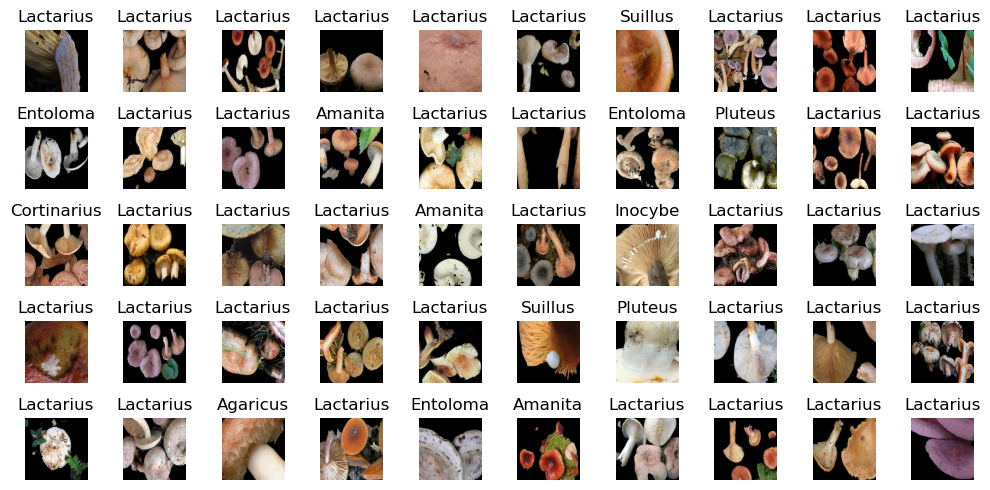

In [264]:
# for q in classes:
get_query(df[df['split'].isin(['val'])]['file'], y_val, y_pred_val_knn, 'Lactarius')

### 10. Conclustions and Pipeline

['Cortinarius', 'Agaricus', 'Entoloma', 'Russula', 'Suillus', 'Inocybe', 'Pluteus', 'Hygrocybe', 'Amanita', 'Boletus', 'Lactarius', 'Exidia']


100%|██████████| 11999/11999 [00:16<00:00, 726.37it/s]


Accuracy: 81.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78        50
           1       0.75      0.66      0.70        50
           2       0.75      0.76      0.75        50
           3       0.81      0.68      0.74        50
           4       0.85      0.92      0.88        50
           5       0.85      0.94      0.90        50
           6       0.86      0.98      0.92        50
           7       0.94      0.94      0.94        50
           8       0.83      0.88      0.85        50
           9       0.79      0.76      0.78        50
          10       0.69      0.70      0.69        50
          11       0.93      0.80      0.86        50

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



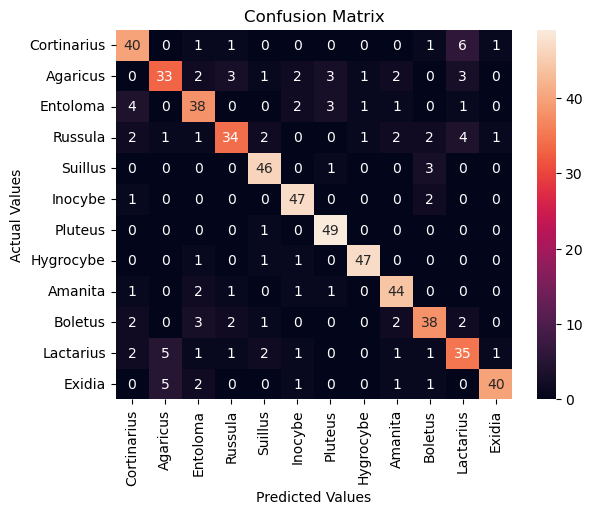

In [265]:
classes = os.listdir(path)

data_split = [0.9, 0.05, 0.05]

# Mapping labels to numeric values
label_to_num = {cls: idx for idx, cls in enumerate(classes)}
num_to_label = {num: label for label, num in label_to_num.items()}

# DataFrame to hold file paths and labels
df_final = pd.DataFrame(columns=['file', 'label', 'split', 'label_num'])

for cls in classes:
    files = os.listdir(os.path.join(path, cls))
    random.shuffle(files)
    
    # File paths and labels
    files = [os.path.join(cls, file) for file in files]
    train_size = int(len(files) * data_split[0])
    val_size = int(len(files) * data_split[1])
    test_size = len(files) - train_size - val_size
    split_list = ['train']*train_size + ['val']*val_size + ['test']*test_size

    df_final = pd.concat([df, pd.DataFrame({
        'file': files,
        'label': [cls] * len(files),
        'split': split_list,
        'label_num': [label_to_num[cls]] * len(files)
    })], ignore_index=True)

print(classes)

df_final = get_sift_features(df_final, path, False, 96)

df_final = df_final.dropna()

sift_descriptors = [item for sublist in df_final[df_final['split'] == 'train']['sift_descriptors'] for item in sublist]
scaler_des = StandardScaler()
sift_descriptors = scaler_des.fit_transform(sift_descriptors)

codebook = cluster(k=50, des_list=sift_descriptors, model='KMeans')

df_final = get_bovw_histograms(df_final, codebook, 50, 'l2')
df_final = get_color_features(df_final, path, 128)

df_final = apply_pca_color_histograms(df_final, 48)

df_final = get_features(df_final)

df_final = apply_pca_color_histograms(df_final, 48)

X_train, y_train = get_matrixs(df_final, ['train', 'val'])
X_test, y_test = get_matrixs(df_final, ['test'])

best_knn = KNeighborsClassifier(metric='manhattan', n_neighbors= 3, weights = 'distance')
best_knn.fit(X_train, y_train)

# Use the trained model to predict the labels of the test set
y_pred_test_knn = best_knn.predict(X_test)
    
# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_test_knn)
print(f"Accuracy: {accuracy_knn * 100:.2f}%")

# Confusion Matrix
cf_matrix_knn = confusion_matrix(y_test, y_pred_test_knn)
ax = sns.heatmap(cf_matrix_knn, annot=True, xticklabels=classes, yticklabels=classes)
ax.set(xlabel="Predicted Values", ylabel="Actual Values", title='Confusion Matrix')

# Classification Report
result_knn = classification_report(y_test, y_pred_test_knn)
print('Classification Report:')
print(result_knn)